Combined Strain-Temperature Model
Combined target statistics:
Mean: -0.0000
Std: 0.9991
Range: [-2.5907, 2.4610]

--- Combined Strain-Temperature Model ---
Intercept (β0): 0.000437
Coefficients (βi): [1.07833217 1.67063924 2.74662125]
R² Score: 0.9978
MSE: 0.002218
RMSE: 0.047098


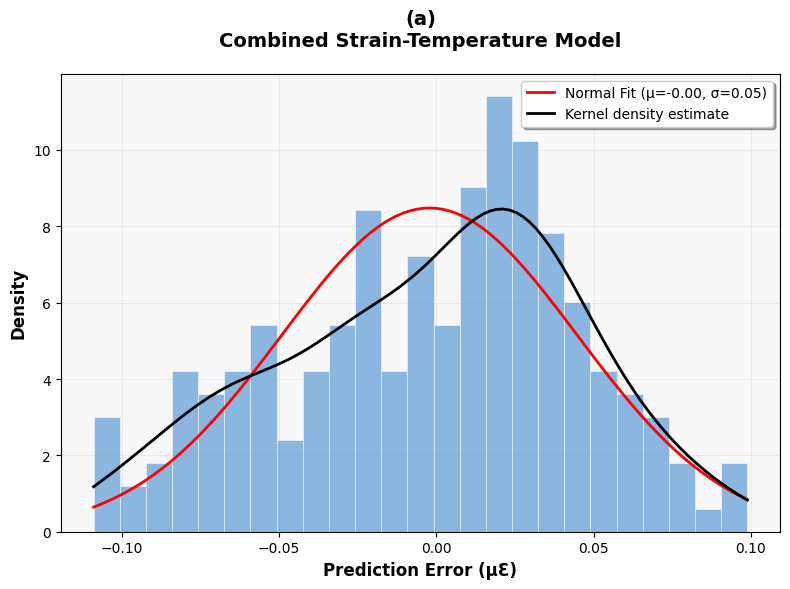


Error Statistics for Combined Strain-Temperature Model:
Mean error: -0.002184
Std error: 0.047165
Skewness: -0.2866
Kurtosis: -0.6029
Shapiro-Wilk normality test: W=0.9798, p=0.005608

--- Individual Component Recovery ---
Strain correlation with recovered: 0.9983
Temperature correlation with recovered: 0.9972

--- Comparison: Combined vs Separate Models ---
Separate Strain Model R²: 0.9968
Separate Temperature Model R²: 0.9947
Combined Model R²: 0.9978


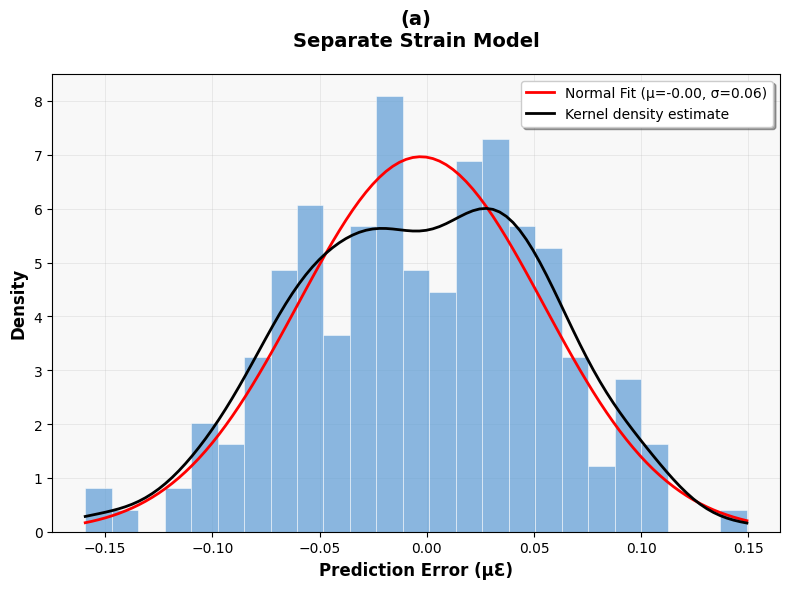


Error Statistics for Separate Strain Model:
Mean error: -0.002841
Std error: 0.057426
Skewness: -0.1206
Kurtosis: -0.4001
Shapiro-Wilk normality test: W=0.9928, p=0.439092


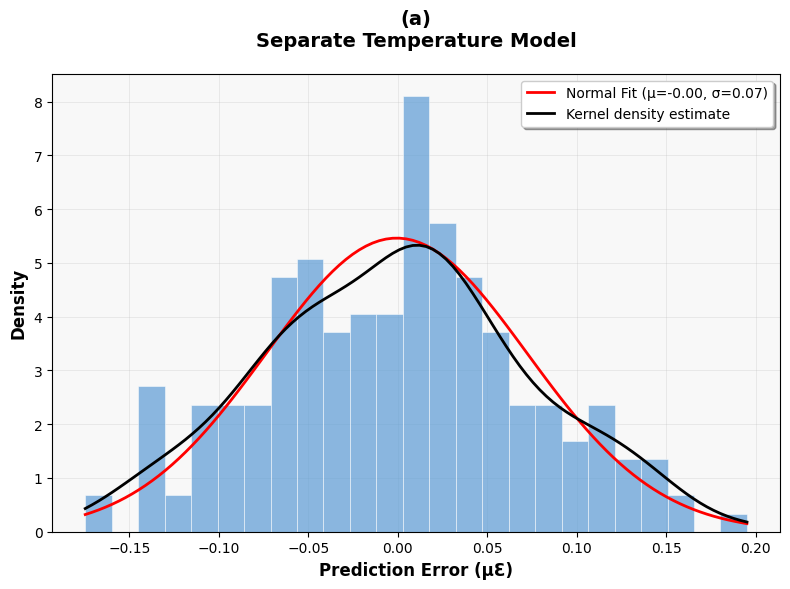


Error Statistics for Separate Temperature Model:
Mean error: -0.000653
Std error: 0.073237
Skewness: 0.0568
Kurtosis: -0.3538
Shapiro-Wilk normality test: W=0.9939, p=0.580181

--- Model Coefficients Analysis ---
Combined Model:
  ΔλBG1 coefficient: 1.078332
  ΔFBG2 coefficient: 1.670639
  ΔFBG3 coefficient: 2.746621

Separate Models:
Strain Model coefficients: [1.09874478 1.65126662 2.7487268 ]
Temperature Model coefficients: [1.03070273 1.71584203 2.74170831]

Enhanced dataset saved: fbg_combined_model_data.csv


In [1]:
#with delta wevelength
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
data = pd.read_csv("fbg_sensor_strain_temperature_data.csv")

# -------------------------------
# BASELINE WAVELENGTH CALCULATION
# -------------------------------
baseline_fbg1 = data['FBG1'].mean()
baseline_fbg2 = data['FBG2'].mean() 
baseline_fbg3 = data['FBG3'].mean()

# Calculate wavelength shifts
data['Delta_FBG1'] = data['FBG1'] - baseline_fbg1
data['Delta_FBG2'] = data['FBG2'] - baseline_fbg2  
data['Delta_FBG3'] = data['FBG3'] - baseline_fbg3

# -------------------------------
# COMBINED STRAIN-TEMPERATURE TARGET
# -------------------------------
# Create combined target using Bragg equation influence
# Δλ/λ = (1-Pe)ε + (α + ξ)ΔT
# Here we create a weighted combination representing total Bragg shift

# Normalize strain and temperature to similar scales
strain_norm = (data['Strain'] - data['Strain'].mean()) / data['Strain'].std()
temp_norm = (data['Temperature'] - data['Temperature'].mean()) / data['Temperature'].std()

# Combined target (you can adjust weights based on your sensor characteristics)
strain_weight = 0.7  # Strain contribution
temp_weight = 0.3    # Temperature contribution

data['Combined_Target'] = strain_weight * strain_norm + temp_weight * temp_norm

print("Combined Strain-Temperature Model")
print("="*50)
print(f"Combined target statistics:")
print(f"Mean: {data['Combined_Target'].mean():.4f}")
print(f"Std: {data['Combined_Target'].std():.4f}")
print(f"Range: [{data['Combined_Target'].min():.4f}, {data['Combined_Target'].max():.4f}]")

# -------------------------------
# MODEL: Combined Prediction
# -------------------------------
X = data[['Delta_FBG1', 'Delta_FBG2', 'Delta_FBG3']]
y = data['Combined_Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model_combined = LinearRegression()
model_combined.fit(X_train, y_train)
y_pred = model_combined.predict(X_test)

print(f"\n--- Combined Strain-Temperature Model ---")
print(f"Intercept (β0): {model_combined.intercept_:.6f}")
print(f"Coefficients (βi): {model_combined.coef_}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")

# -------------------------------
# PROFESSIONAL ERROR DISTRIBUTION PLOTS
# -------------------------------
def create_professional_error_plot(y_true, y_pred, title, save_name=None):
    """Create professional error distribution plot matching the provided style"""
    
    # Calculate errors
    errors = y_true - y_pred
    
    # Set style
    plt.style.use('default')
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Create histogram
    n, bins, patches = ax.hist(errors, bins=25, density=True, alpha=0.7, 
                              color='#5B9BD5', edgecolor='white', linewidth=0.5)
    
    # Fit normal distribution
    mu, sigma = stats.norm.fit(errors)
    x = np.linspace(errors.min(), errors.max(), 100)
    normal_fit = stats.norm.pdf(x, mu, sigma)
    
    # Plot normal fit line
    ax.plot(x, normal_fit, 'r-', linewidth=2, 
            label=f'Normal Fit (μ={mu:.2f}, σ={sigma:.2f})')
    
    # Kernel density estimate
    kde_x = np.linspace(errors.min(), errors.max(), 100)
    kde = stats.gaussian_kde(errors)
    ax.plot(kde_x, kde(kde_x), 'k-', linewidth=2, 
            label='Kernel density estimate')
    
    # Styling
    ax.set_xlabel('Prediction Error (μƐ)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'(a)\n{title}', fontsize=14, fontweight='bold', pad=20)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Legend
    ax.legend(frameon=True, fancybox=True, shadow=True, 
             loc='upper right', fontsize=10)
    
    # Set background
    ax.set_facecolor('#F8F8F8')
    fig.patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    
    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nError Statistics for {title}:")
    print(f"Mean error: {errors.mean():.6f}")
    print(f"Std error: {errors.std():.6f}")
    print(f"Skewness: {stats.skew(errors):.4f}")
    print(f"Kurtosis: {stats.kurtosis(errors):.4f}")
    
    # Normality test
    shapiro_stat, shapiro_p = stats.shapiro(errors)
    print(f"Shapiro-Wilk normality test: W={shapiro_stat:.4f}, p={shapiro_p:.6f}")

# Create error distribution plot
create_professional_error_plot(y_test, y_pred, 
                              "Combined Strain-Temperature Model", 
                              "combined_model_errors.png")

# -------------------------------
# INDIVIDUAL COMPONENT ANALYSIS
# -------------------------------
# Predict individual strain and temperature from combined model
print(f"\n--- Individual Component Recovery ---")

# Use the combined model to predict individual components
# This requires inverse transformation
combined_pred = model_combined.predict(X_test)

# Recover individual predictions (approximate)
# This is a simplified approach - in practice you might need more sophisticated decoupling
strain_recovered = combined_pred / strain_weight
temp_recovered = combined_pred / temp_weight

# Calculate correlations with actual values
strain_test = (data.loc[X_test.index, 'Strain'] - data['Strain'].mean()) / data['Strain'].std()
temp_test = (data.loc[X_test.index, 'Temperature'] - data['Temperature'].mean()) / data['Temperature'].std()

strain_corr = np.corrcoef(strain_recovered, strain_test)[0,1]
temp_corr = np.corrcoef(temp_recovered, temp_test)[0,1]

print(f"Strain correlation with recovered: {strain_corr:.4f}")
print(f"Temperature correlation with recovered: {temp_corr:.4f}")

# -------------------------------
# COMPARISON WITH SEPARATE MODELS
# -------------------------------
print(f"\n--- Comparison: Combined vs Separate Models ---")

# Separate strain model
model_strain = LinearRegression()
model_strain.fit(X_train, (data.loc[X_train.index, 'Strain'] - data['Strain'].mean()) / data['Strain'].std())
strain_pred_sep = model_strain.predict(X_test)
strain_r2_sep = r2_score(strain_test, strain_pred_sep)

# Separate temperature model  
model_temp = LinearRegression()
model_temp.fit(X_train, (data.loc[X_train.index, 'Temperature'] - data['Temperature'].mean()) / data['Temperature'].std())
temp_pred_sep = model_temp.predict(X_test)
temp_r2_sep = r2_score(temp_test, temp_pred_sep)

print(f"Separate Strain Model R²: {strain_r2_sep:.4f}")
print(f"Separate Temperature Model R²: {temp_r2_sep:.4f}")
print(f"Combined Model R²: {r2_score(y_test, y_pred):.4f}")

# Create comparison error plots
errors_strain_sep = strain_test - strain_pred_sep
errors_temp_sep = temp_test - temp_pred_sep

create_professional_error_plot(strain_test, strain_pred_sep, 
                              "Separate Strain Model", 
                              "strain_separate_errors.png")

create_professional_error_plot(temp_test, temp_pred_sep, 
                              "Separate Temperature Model", 
                              "temp_separate_errors.png")

# -------------------------------
# MODEL COEFFICIENTS ANALYSIS
# -------------------------------
print(f"\n--- Model Coefficients Analysis ---")
print(f"Combined Model:")
print(f"  ΔλBG1 coefficient: {model_combined.coef_[0]:.6f}")
print(f"  ΔFBG2 coefficient: {model_combined.coef_[1]:.6f}")  
print(f"  ΔFBG3 coefficient: {model_combined.coef_[2]:.6f}")

print(f"\nSeparate Models:")
print(f"Strain Model coefficients: {model_strain.coef_}")
print(f"Temperature Model coefficients: {model_temp.coef_}")

# Save enhanced dataset
data['Combined_Target'] = data['Combined_Target']
data.to_csv("fbg_combined_model_data.csv", index=False)
print(f"\nEnhanced dataset saved: fbg_combined_model_data.csv")

Combined Strain-Temperature Model
Combined target statistics:
Mean: -0.0000
Std: 0.9991
Range: [-2.5907, 2.4610]

--- Combined Strain-Temperature Model ---
Intercept (β0): -2.732707
Coefficients (βi): [1.07833217 1.67063924 2.74662125]
R² Score: 0.9978
MSE: 0.002218
RMSE: 0.047098


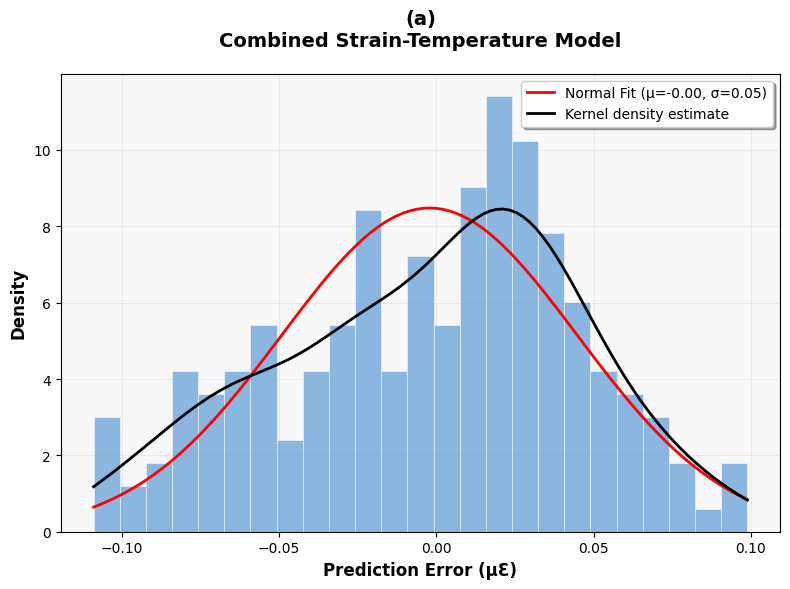


Error Statistics for Combined Strain-Temperature Model:
Mean error: -0.002184
Std error: 0.047165
Skewness: -0.2866
Kurtosis: -0.6029
Shapiro-Wilk normality test: W=0.9798, p=0.005608

--- Individual Component Recovery ---
Strain correlation with recovered: 0.9983
Temperature correlation with recovered: 0.9972

--- Comparison: Combined vs Separate Models ---
Separate Strain Model R²: 0.9968
Separate Temperature Model R²: 0.9947
Combined Model R²: 0.9978


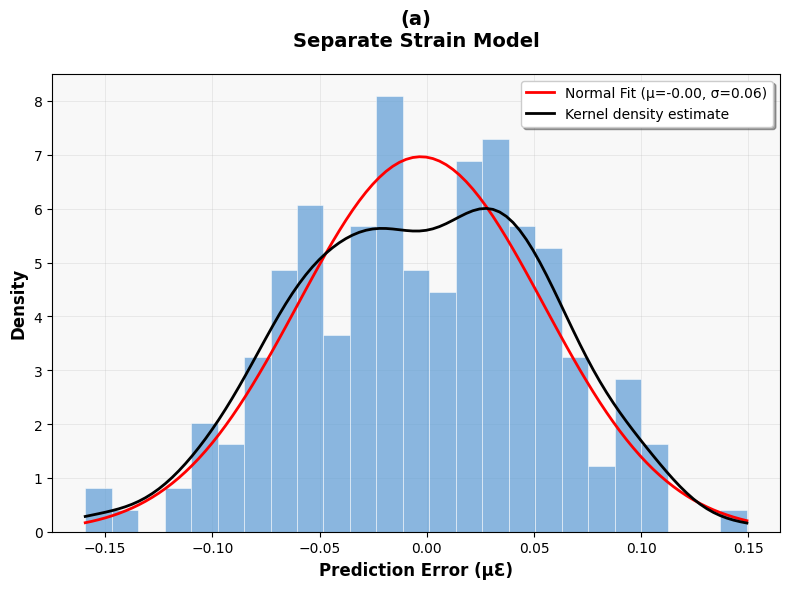


Error Statistics for Separate Strain Model:
Mean error: -0.002841
Std error: 0.057426
Skewness: -0.1206
Kurtosis: -0.4001
Shapiro-Wilk normality test: W=0.9928, p=0.439092


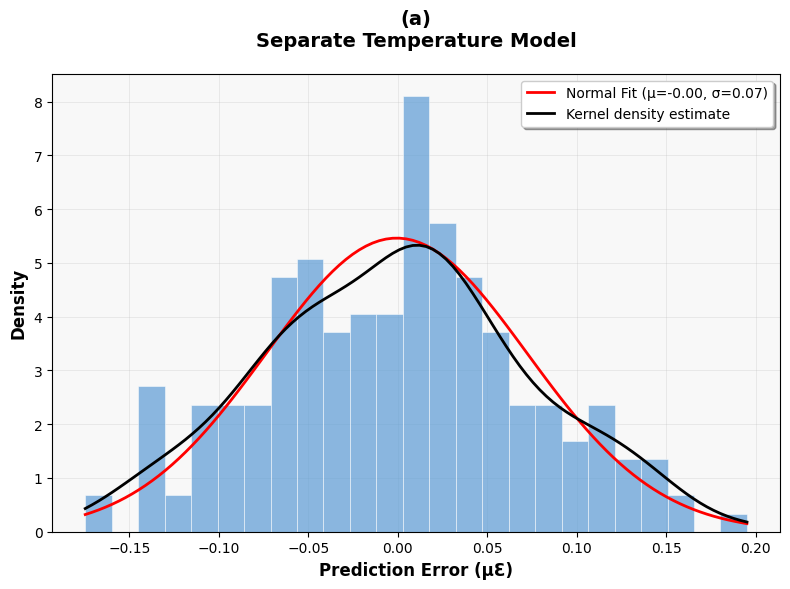


Error Statistics for Separate Temperature Model:
Mean error: -0.000653
Std error: 0.073237
Skewness: 0.0568
Kurtosis: -0.3538
Shapiro-Wilk normality test: W=0.9939, p=0.580181

--- Model Coefficients Analysis ---
Combined Model:
  ΔλBG1 coefficient: 1.078332
  ΔFBG2 coefficient: 1.670639
  ΔFBG3 coefficient: 2.746621

Separate Models:
Strain Model coefficients: [1.09874478 1.65126662 2.7487268 ]
Temperature Model coefficients: [1.03070273 1.71584203 2.74170831]

Enhanced dataset saved: fbg_combined_model_data.csv


In [2]:
#raw wavelength
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
data = pd.read_csv("fbg_sensor_strain_temperature_data.csv")

# Using raw wavelengths directly (no delta calculation)

# -------------------------------
# COMBINED STRAIN-TEMPERATURE TARGET
# -------------------------------
# Create combined target using Bragg equation influence
# Δλ/λ = (1-Pe)ε + (α + ξ)ΔT
# Here we create a weighted combination representing total Bragg shift

# Normalize strain and temperature to similar scales
strain_norm = (data['Strain'] - data['Strain'].mean()) / data['Strain'].std()
temp_norm = (data['Temperature'] - data['Temperature'].mean()) / data['Temperature'].std()

# Combined target (you can adjust weights based on your sensor characteristics)
strain_weight = 0.7  # Strain contribution
temp_weight = 0.3    # Temperature contribution

data['Combined_Target'] = strain_weight * strain_norm + temp_weight * temp_norm

print("Combined Strain-Temperature Model")
print("="*50)
print(f"Combined target statistics:")
print(f"Mean: {data['Combined_Target'].mean():.4f}")
print(f"Std: {data['Combined_Target'].std():.4f}")
print(f"Range: [{data['Combined_Target'].min():.4f}, {data['Combined_Target'].max():.4f}]")

# -------------------------------
# MODEL: Combined Prediction
# -------------------------------
X = data[['FBG1', 'FBG2', 'FBG3']]
y = data['Combined_Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model_combined = LinearRegression()
model_combined.fit(X_train, y_train)
y_pred = model_combined.predict(X_test)

print(f"\n--- Combined Strain-Temperature Model ---")
print(f"Intercept (β0): {model_combined.intercept_:.6f}")
print(f"Coefficients (βi): {model_combined.coef_}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")

# -------------------------------
# PROFESSIONAL ERROR DISTRIBUTION PLOTS
# -------------------------------
def create_professional_error_plot(y_true, y_pred, title, save_name=None):
    """Create professional error distribution plot matching the provided style"""
    
    # Calculate errors
    errors = y_true - y_pred
    
    # Set style
    plt.style.use('default')
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Create histogram
    n, bins, patches = ax.hist(errors, bins=25, density=True, alpha=0.7, 
                              color='#5B9BD5', edgecolor='white', linewidth=0.5)
    
    # Fit normal distribution
    mu, sigma = stats.norm.fit(errors)
    x = np.linspace(errors.min(), errors.max(), 100)
    normal_fit = stats.norm.pdf(x, mu, sigma)
    
    # Plot normal fit line
    ax.plot(x, normal_fit, 'r-', linewidth=2, 
            label=f'Normal Fit (μ={mu:.2f}, σ={sigma:.2f})')
    
    # Kernel density estimate
    kde_x = np.linspace(errors.min(), errors.max(), 100)
    kde = stats.gaussian_kde(errors)
    ax.plot(kde_x, kde(kde_x), 'k-', linewidth=2, 
            label='Kernel density estimate')
    
    # Styling
    ax.set_xlabel('Prediction Error (μƐ)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'(a)\n{title}', fontsize=14, fontweight='bold', pad=20)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Legend
    ax.legend(frameon=True, fancybox=True, shadow=True, 
             loc='upper right', fontsize=10)
    
    # Set background
    ax.set_facecolor('#F8F8F8')
    fig.patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    
    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nError Statistics for {title}:")
    print(f"Mean error: {errors.mean():.6f}")
    print(f"Std error: {errors.std():.6f}")
    print(f"Skewness: {stats.skew(errors):.4f}")
    print(f"Kurtosis: {stats.kurtosis(errors):.4f}")
    
    # Normality test
    shapiro_stat, shapiro_p = stats.shapiro(errors)
    print(f"Shapiro-Wilk normality test: W={shapiro_stat:.4f}, p={shapiro_p:.6f}")

# Create error distribution plot
create_professional_error_plot(y_test, y_pred, 
                              "Combined Strain-Temperature Model", 
                              "combined_model_errors.png")

# -------------------------------
# INDIVIDUAL COMPONENT ANALYSIS
# -------------------------------
# Predict individual strain and temperature from combined model
print(f"\n--- Individual Component Recovery ---")

# Use the combined model to predict individual components
# This requires inverse transformation
combined_pred = model_combined.predict(X_test)

# Recover individual predictions (approximate)
# This is a simplified approach - in practice you might need more sophisticated decoupling
strain_recovered = combined_pred / strain_weight
temp_recovered = combined_pred / temp_weight

# Calculate correlations with actual values
strain_test = (data.loc[X_test.index, 'Strain'] - data['Strain'].mean()) / data['Strain'].std()
temp_test = (data.loc[X_test.index, 'Temperature'] - data['Temperature'].mean()) / data['Temperature'].std()

strain_corr = np.corrcoef(strain_recovered, strain_test)[0,1]
temp_corr = np.corrcoef(temp_recovered, temp_test)[0,1]

print(f"Strain correlation with recovered: {strain_corr:.4f}")
print(f"Temperature correlation with recovered: {temp_corr:.4f}")

# -------------------------------
# COMPARISON WITH SEPARATE MODELS
# -------------------------------
print(f"\n--- Comparison: Combined vs Separate Models ---")

# Separate strain model
model_strain = LinearRegression()
model_strain.fit(X_train, (data.loc[X_train.index, 'Strain'] - data['Strain'].mean()) / data['Strain'].std())
strain_pred_sep = model_strain.predict(X_test)
strain_r2_sep = r2_score(strain_test, strain_pred_sep)

# Separate temperature model  
model_temp = LinearRegression()
model_temp.fit(X_train, (data.loc[X_train.index, 'Temperature'] - data['Temperature'].mean()) / data['Temperature'].std())
temp_pred_sep = model_temp.predict(X_test)
temp_r2_sep = r2_score(temp_test, temp_pred_sep)

print(f"Separate Strain Model R²: {strain_r2_sep:.4f}")
print(f"Separate Temperature Model R²: {temp_r2_sep:.4f}")
print(f"Combined Model R²: {r2_score(y_test, y_pred):.4f}")

# Create comparison error plots
errors_strain_sep = strain_test - strain_pred_sep
errors_temp_sep = temp_test - temp_pred_sep

create_professional_error_plot(strain_test, strain_pred_sep, 
                              "Separate Strain Model", 
                              "strain_separate_errors.png")

create_professional_error_plot(temp_test, temp_pred_sep, 
                              "Separate Temperature Model", 
                              "temp_separate_errors.png")

# -------------------------------
# MODEL COEFFICIENTS ANALYSIS
# -------------------------------
print(f"\n--- Model Coefficients Analysis ---")
print(f"Combined Model:")
print(f"  ΔλBG1 coefficient: {model_combined.coef_[0]:.6f}")
print(f"  ΔFBG2 coefficient: {model_combined.coef_[1]:.6f}")  
print(f"  ΔFBG3 coefficient: {model_combined.coef_[2]:.6f}")

print(f"\nSeparate Models:")
print(f"Strain Model coefficients: {model_strain.coef_}")
print(f"Temperature Model coefficients: {model_temp.coef_}")

# Save enhanced dataset
data['Combined_Target'] = data['Combined_Target']
data.to_csv("fbg_combined_model_data.csv", index=False)
print(f"\nEnhanced dataset saved: fbg_combined_model_data.csv")